# Transactions

## This notebook is used to look at transactions usage in Ripple. 

In the first part we compute general statistics about transactions and in the second part we look at transactions currencies.

### 0. Preliminaries
Import the needed libraries, read the transactions data and clean it.

In [1]:
import json
import pandas as pd
import time
import ccy 
from tqdm import tqdm_notebook as tqdm
import collections
from collections import Counter
import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib.gridspec import GridSpec

import operator

import urllib.request

import seaborn as sns

import re

import math

In [2]:
from ripple_api import RippleDataAPIClient
api = RippleDataAPIClient('https://data.ripple.com')

In [3]:
from coinmarketcap import Market
coinmarketcap = Market()

In [4]:
from currency_converter import CurrencyConverter
c = CurrencyConverter()

Read the data, run only once 

In [5]:
data = []
with open('../data/transactions/more-txs-from-missing-parsed.json') as f:
    for line in tqdm(list(f)):
        data.append(json.loads(line))
with open('../data/transactions/final_txs_2017.json') as f:
    for line in tqdm(list(f)):
        data.append(json.loads(line))

Try to recover some senderCurrency field that are missing. Getting currency of link with sender

In [6]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'senderCurrency' not in txn.keys() and 'links' in txn.keys() :
            sender = txn['sender']
            for link in txn['links']:
                if sender == link['node1'] and sender == link['holder'] and link['isIncr'] == False:
                    txn['senderCurrency'] = link['currency']  
                elif sender == link['node1'] and link['holder'] == link['node2'] and link['isIncr'] == True: 
                     txn['senderCurrency'] = link['currency']  
                elif sender == link['node2'] and sender == link['holder'] and link['isIncr'] == False:
                    txn['senderCurrency'] = link['currency']  
                elif sender == link['node2'] and link['holder'] == link['node1'] and link['isIncr'] == True:
                    txn['senderCurrency'] = link['currency']              

Uniform the data because we have fields 'actualReceiverCurrency' and 'receiverCurrency' so put them all under 'receiverCurrency'.

In [7]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'actualReceiverCurrency' in txn.keys() :
            txn['receiverCurrency'] = txn['actualReceiverCurrency']
            del txn['actualReceiverCurrency']

Uniform the data because we have fields 'actualReceiverAmount' and 'receiverCurrency' so put them all under 'receiverAmount'.

In [8]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'actualReceiverAmount' in txn.keys():
            txn['receiverAmount'] = txn['actualReceiverAmount']
            del txn['actualReceiverAmount']

Recover the senderCurrency, if not done before from the links then it is usually XRP.

In [9]:
for index in tqdm(range(len(data))):
    txn = data[index]
    if txn['success'] == 'tesSUCCESS':
        if 'senderCurrency' not in txn.keys():
            txn['senderCurrency'] = txn['receiverCurrency']    

In [11]:
print(json.dumps(data[1],indent = 4))
print(json.dumps(data[7],indent = 4))

{
    "fee": 1e-05,
    "hash": "3F7A1B3A771D477B03104E86CE73790BB8C8E516BEE680BB4AD9893444D21CF3",
    "sender": "rHb9CJAWyB4rj91VRWn96DkukG4bwdtyTh",
    "success": "tesSUCCESS",
    "XRPAcc": [
        {
            "isIncr": false,
            "account": "rHb9CJAWyB4rj91VRWn96DkukG4bwdtyTh",
            "amount": 1.100000000064938e-05
        },
        {
            "isIncr": true,
            "account": "rbvFfuUysurzPHq5kgs53A16j5svbFxgv",
            "amount": 1.0000001111620804e-06
        }
    ],
    "flags": "",
    "receiver": "rbvFfuUysurzPHq5kgs53A16j5svbFxgv",
    "date": "2013-06-29T13:10:20+00:00",
    "actualIssuerReceiver": "--",
    "receiverCurrency": "XRP",
    "receiverAmount": "0.000001",
    "senderCurrency": "XRP"
}
{
    "fee": 1.2e-05,
    "issuerReceiver": "--",
    "sender": "rQ9ArM8TdHmeQHvd969nQPP1TZosBhzdXg",
    "success": "tesSUCCESS",
    "paths": [
        [
            {
                "account": "ruazs5h1qEsqpke88pcqnaseXdm6od2xc"
            },


### 1. Statistics about transactions
We now have clean data, let's compute some statistics over it.

#### First hops
Are there prefered first hops ? Are they gateways ?

In [12]:
with open('../data/gateways/gateways_address_to_name.pickle', 'rb') as f:
    gateways_address_to_name = pickle.load(f) #load from disk

In [13]:
wallets_first_hop = collections.defaultdict(list)
for txn in tqdm(data):
    sender = txn["sender"]
    if 'links' in txn.keys():
        for link in txn["links"]:
            if sender == link['node1'] and sender == link['holder'] and link['isIncr'] == False:
                wallets_first_hop[sender].append(link["node2"])
            elif sender == link['node1'] and link['holder'] == link['node2'] and link['isIncr'] == True: 
                wallets_first_hop[sender].append(link["node2"])
            elif sender == link['node2'] and sender == link['holder'] and link['isIncr'] == False:
                wallets_first_hop[sender].append(link["node1"])
            elif sender == link['node2'] and link['holder'] == link['node1'] and link['isIncr'] == True:
                wallets_first_hop[sender].append(link["node1"])

In [19]:
wallet_two_most_common_hops = {}
count_unique_first_hop = 0
count_unique_first_hop_if_more_than_one_transaction = 0
for wallet in tqdm(wallets_first_hop.keys()):
    counter = collections.Counter(wallets_first_hop[wallet]) # count the appeaence of each each for the wallet
    wallet_two_most_common_hops[wallet] = counter.most_common(2) #get the two most commun hop for the wallet
    if len(wallet_two_most_hops[wallet]) == 1: #only one first hop
        count_unique_first_hop += 1
        for a,b in wallet_two_most_hops[wallet]:
            if(b != 1): #the unique hop appears in more that one time
                count_unique_first_hop_if_more_than_one_transaction += 1

In [20]:
print("There are " + str(count_unique_first_hop/len(wallet_two_most_hops)*100) + "% of wallets that uses always same first hop" +
      " and only " + str(count_unique_first_hop_if_more_than_one_transaction/len(wallet_two_most_hops)*100) + "% if we consider wallets that did more than 1 transaction")

There are 85.06805129415467% of wallets that uses always same first hop and only 41.03139013452915% if we consider wallets that did more than 1 transaction


In [21]:
first_hops = []
for wallet in tqdm(wallets_first_hop.keys()):
    for hop in list(set(wallets_first_hop[wallet])):
        if hop not in first_hops:
            first_hops.append(hop)

In [24]:
inter = list(set(gateways_address_to_name.keys()) & set(first_hops))

In [25]:
print("From the first hops only "+ str(len(inter)/len(first_hops)*100) + "% are know gateways.")

From the first hops only 3.389830508474576% are know gateways.


#### No paths
We now compute how many transactions does not use paths

In [26]:
all_senders = set()
sender_with_paths = set()
all_txn = 0
txn_with_paths = 0
for txn in tqdm(data):
    sender = txn['sender']
    all_senders.add(sender)
    all_txn+=1
    if 'links' in txn.keys(): 
        sender_with_paths.add(sender)  
        txn_with_paths+=1

In [27]:
direct_sender = all_senders - sender_with_paths
direct_txn = all_txn - txn_with_paths

In [28]:
print('We have',len(direct_sender)/len(all_senders)*100,'% of senders that use only direct transactions')

We have 79.74224786535423 % of senders that use only direct transactions


In [29]:
print('We have' ,direct_txn/all_txn*100,'% of transactions that are direct')

We have 87.43271495385557 % of transactions that are direct


#### Occurence of senders

We want to know it senders appears several times in transactions

In [31]:
all_senders = []
for txn in tqdm(data):
    all_senders.append(txn["sender"])

In [32]:
nb_txn_by_sender = Counter(all_senders).most_common() #count nb of occurences of each sender and sort them reverse

In [33]:
set_senders = set(all_senders) #senders with no duplicates

In [34]:
senders_with_at_least_2_txn = [ sender for sender, occurence in tqdm(list(nb_txn_by_sender)) if occurence > 1 ]

In [35]:
print("There are", len(senders_with_at_least_2_txn)/len(set_senders)*100, "% of senders than appears at least two times")

There are 61.45532827880141 % of senders than appears at least two times


### 2. Currency of transactions
Let now look at the currencies of Ripple transactions

#### Currency of direct transactions
We now look at currencies of direct transactions, we should only find that ripple appears here.

In [39]:
currency_direct_txn_not_XRP = set()
count_direct_txn_not_XRP = 0
count_direct_txn_XRP = 0
for i in tqdm(range(len(data))):
    txn = data[i]
    if txn['success'] == 'tesSUCCESS':
        #direct
        if 'links' not in txn.keys():
            if 'senderCurrency' in txn.keys():
                if txn['senderCurrency'] != 'XRP':
                    currency_direct_txn_not_XRP.add(txn['senderCurrency'])
                    count_direct_txn_not_XRP += 1
            else:
                count_direct_txn_XRP += 1
        #direct (1 link) 
        else:
            if len(txn['links']) <= 1:
                if 'offers' not in txn.keys():
                    count_direct_txn_XRP += 1

In [40]:
print("There are", count_direct_txn_not_XRP/(count_direct_txn_not_XRP+count_direct_txn_XRP) * 100,"% of direct payments in other curencies that XRP")

There are 1.1378474165267674 % of direct payments in other curencies that XRP


This result is surprising, it should not be the case that we have direct transactions in other currency that XRP.

We now look if the currencies that appears in direct transactions are offered by gateways

In [41]:
gateways = api.get_all_gateways()
online_gateways = ['SnapSwap','Gatehub Fifth','Bitstamp','Payroutes','WisePass','The Rock Trading','RippleChina','DotPayco','Coinex','Ripple Fox','Lake BTC','Bitso','GBI','Gatehub','EXRP','BPG']
online_gateways_dict = collections.defaultdict(list)
for currency,list_gateways in tqdm(gateways.items()):
    for gateway in list_gateways:
        if gateway['name'] in online_gateways:
            online_gateways_dict[currency].append(gateway)

In [42]:
online_gateways_dict = dict(online_gateways_dict)

In [43]:
currency_direct_payments_not_offered_by_gateways = 0
real_currency_direct_payments_not_offered_by_gateways = 0
currency_direct_payments_not_offered_by_online_gateways = 0
real_currency_direct_payments_not_offered_by_online_gateways = 0
for currency in tqdm(currency_direct_txn_not_XRP):
    
    #all gateways
    if currency not in gateways.keys():
        currency_direct_payments_not_offered_by_gateways += 1
        if currency == ccy.currency(currency):
            real_currency_direct_payments_not_offered_by_gateways += 1

    #online gateways
    if currency not in online_gateways_dict.keys():
        currency_direct_payments_not_offered_by_online_gateways += 1
        if currency == ccy.currency(currency):
            real_currency_direct_payments_not_offered_by_online_gateways += 1        

In [44]:
print("There are", currency_direct_payments_not_offered_by_gateways, "currency that appears in direct payments that are not offered by gateways, of which",real_currency_direct_payments_not_offered_by_gateways, "are real world currencies")
print("There are", currency_direct_payments_not_offered_by_online_gateways, "currency that appears in direct payments that are not offered by online gateways, of which",real_currency_direct_payments_not_offered_by_online_gateways, "are real world currencies")

There are 23 currency that appears in direct payments that are not offered by gateways, of which 0 are real world currencies
There are 25 currency that appears in direct payments that are not offered by online gateways, of which 0 are real world currencies


#### Currency of transactions
We have a counter of appearance for each currency that is in a transaction. We look at each transaction and increment the counter for the currency of the sender and of the receiver. Then we order by decreasing occurences.

In [21]:
crypto = coinmarketcap.ticker(start=0, convert='XRP') #converter from currency to XRP

In [22]:
currency_to_XRP = {}
for crypto_id,details in tqdm(crypto['data'].items()):
    if details['symbol'] == 'XRP':
        currency_to_XRP['USD'] = details['quotes']['USD']['price']
    else:
        currency_to_XRP[details['symbol']] = details['quotes']['XRP']['price']

In [49]:
nb_of_currencies = 10

In [53]:
currency_usage_nb_txns = {}
currency_usage_volume = {}

for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        sender_curr = txn['senderCurrency']
        receiver_curr = txn['receiverCurrency']
        currency_usage_nb_txns[sender_curr] = currency_usage_nb_txns.get(sender_curr,0) + 1 #dict {sender_currency :count}
        currency_usage_nb_txns[receiver_curr] = currency_usage_nb_txns.get(receiver_curr,0) + 1 #dict {receiver_currency :count}
        
        if receiver_curr == 'XRP':
            rate = 1
        else:
            if receiver_curr in currency_to_XRP.keys():
                rate = currency_to_XRP[receiver_curr]  
            else: 
                try:
                    rate = c.convert(1, 'USD', receiver_curr) * currency_to_XRP['USD']
                except:
                    rate = 0
        
        amount = rate * float(txn['receiverAmount'])
        currency_usage_volume[sender_curr] = currency_usage_volume.get(sender_curr,0) + amount
        currency_usage_volume[receiver_curr] = currency_usage_volume.get(receiver_curr,0) + amount


currency_usage_nb_txns = collections.OrderedDict(sorted(currency_usage_nb_txns.items(), key=operator.itemgetter(1),reverse = True)) #order descreasing
currency_usage_volume = collections.OrderedDict(sorted(currency_usage_volume.items(), key=operator.itemgetter(1),reverse = True)) #order descreasing

We plot the top 10 currencies.

In [54]:
def plot_top_currencies(sorted_volume,ylabel,first_N):
    currencies = list(sorted_volume.keys())[0:first_N]
    my_list = []
    for currency in currencies:
        try:
            my_list.append('\n('+ccy.country(ccy.currency(currency).default_country)+')')
        except :
            my_list.append('')
    labels = [a+b for a,b in zip(currencies,my_list)]
    
    x_pos = np.arange(len(currencies))
    count = list(sorted_volume.values())[0:first_N]
 
    
    plt.figure(figsize=(13,8))

    plt.bar(x_pos, count) #bar plot
    
    plt.xticks(x_pos, labels)
    plt.ylabel(ylabel)
    plt.xlabel('Currencies')
    plt.title(ylabel +' for top ' + str(first_N) + ' currencies')
    
    plt.savefig('../visualisations/top_' + str(first_N) + '_currencies_in' + ylabel +'.png',dpi = 255)

    plt.show()

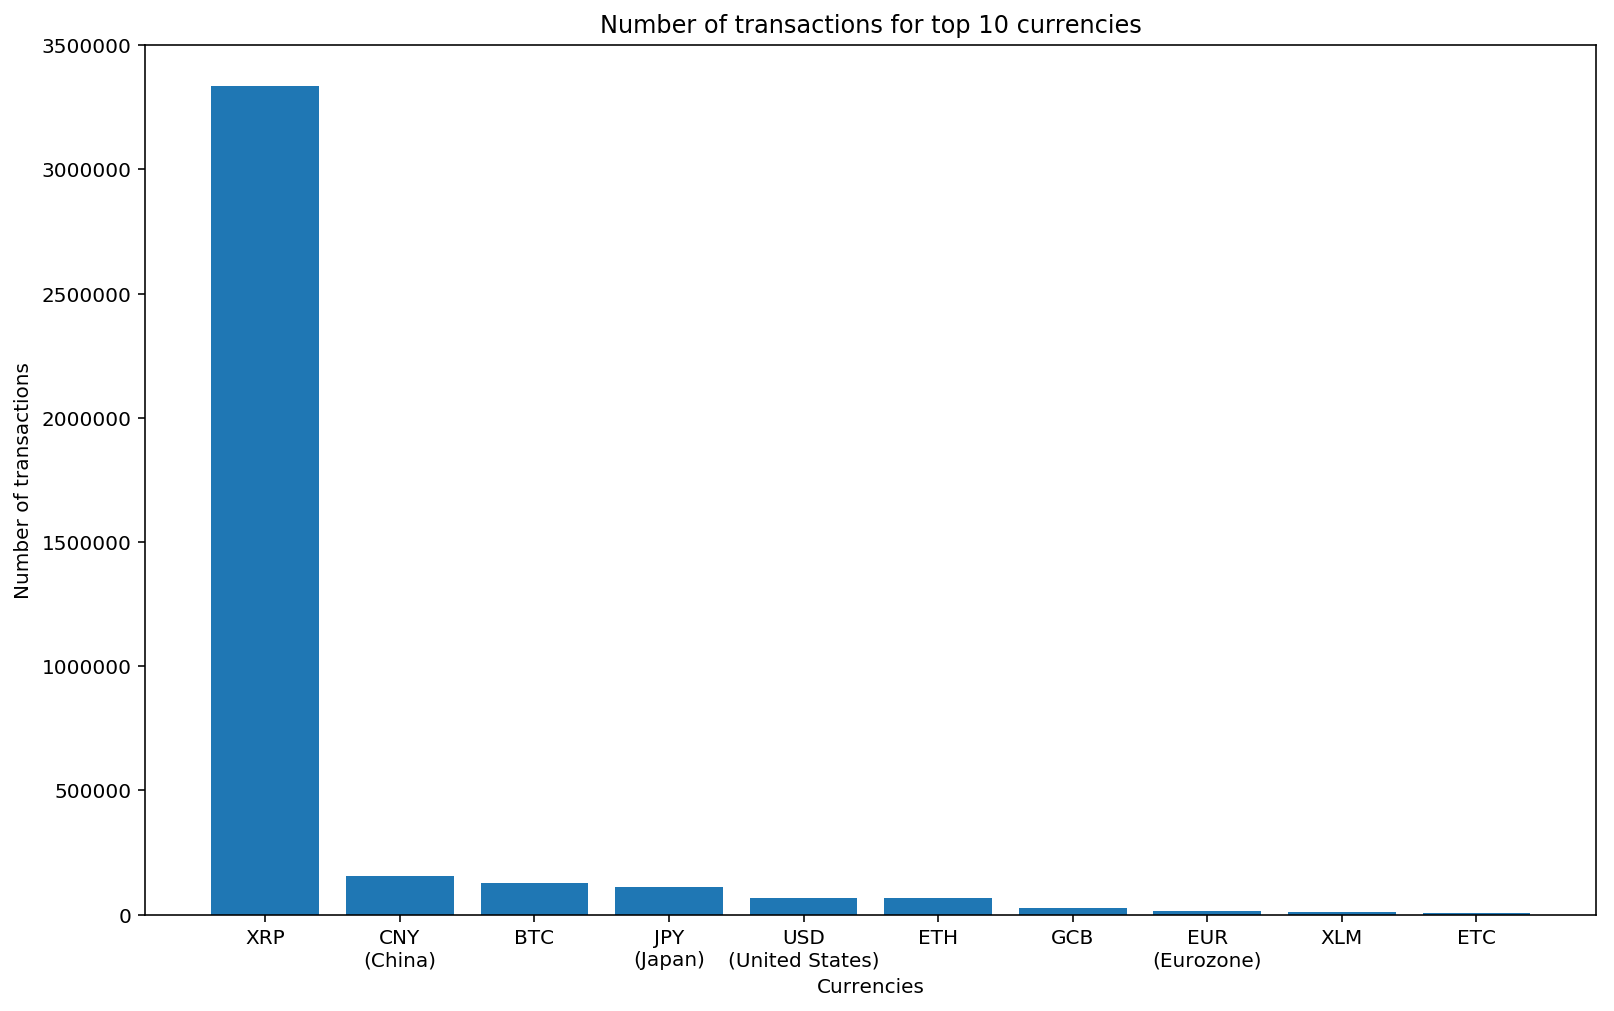

In [55]:
plot_top_currencies(currency_usage_nb_txns,'Number of transactions',nb_of_currencies)

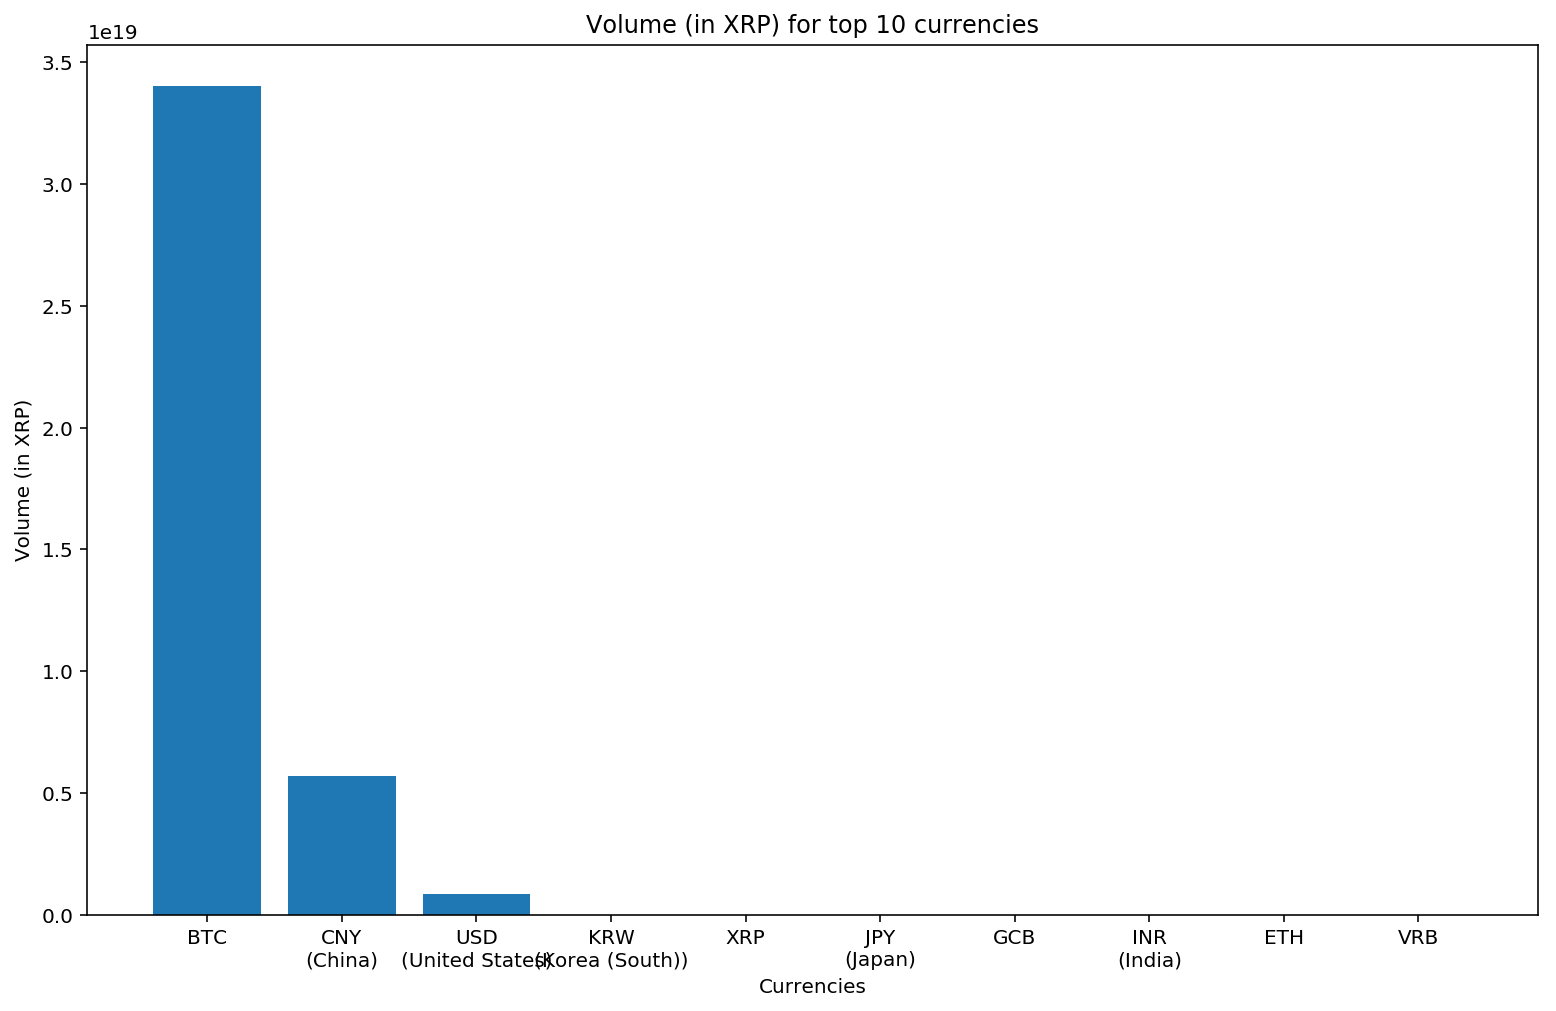

In [56]:
plot_top_currencies(currency_usage_volume,'Volume (in XRP)',nb_of_currencies)

#### Sender and receiver currency pairs
We now look at how sender and receiver currency are related

In [11]:
count_currency = {}
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        count_currency[txn['senderCurrency']] = count_currency.get(txn['senderCurrency'],0) + 1 #dict {sender_currency :count}
        count_currency[txn['receiverCurrency']] = count_currency.get(txn['receiverCurrency'],0) + 1 #dict {receiver_currency :count}
count_currency = collections.OrderedDict(sorted(count_currency.items(), key=operator.itemgetter(1),reverse = True)) #order descreasing

In [12]:
nb_of_top_currencies = 15

In [13]:
#We assign a number to the top 15 currencies in the number of transactions
currencies = dict()
index = 0
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        if txn['senderCurrency'] not in currencies.keys() and txn['senderCurrency'] in list(count_currency.keys())[0:nb_of_top_currencies]:
            currencies[txn['senderCurrency']] = index
            index+=1

In [14]:
my_list = []
for currency in currencies.keys():
    try:
        my_list.append('\n('+ccy.country(ccy.currency(currency).default_country)+')')
    except :
        my_list.append('')

In [15]:
labels = [a+b for a,b in zip(currencies.keys(),my_list)] #add country to currency name

For top used currencies in senders, what are most popular receiver currencies

In [16]:
sender_currency_to_receiver_currency = collections.defaultdict(dict) # dict {sender_curr : {receiver_curr: count}}
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        sender_curr = txn['senderCurrency']
        receiver_curr = txn['receiverCurrency']
        if sender_curr in currencies.keys() and receiver_curr in currencies.keys():
            sender_currency_to_receiver_currency[sender_curr] = sender_currency_to_receiver_currency.get(sender_curr,{})
            sender_currency_to_receiver_currency[sender_curr][receiver_curr] = sender_currency_to_receiver_currency[sender_curr].get(receiver_curr,0) + 1

We create the matrix for the heat-map

In [17]:
matrix = np.zeros((len(currencies.keys()),len(currencies.keys())))
for sender_currency,repartition in tqdm(sender_currency_to_receiver_currency.items()):
    if sender_currency in list(count_currency.keys())[0:nb_of_top_currencies]:
        for receiver_currency,count in repartition.items():
            if receiver_currency in list(count_currency.keys())[0:nb_of_top_currencies]:
                matrix[currencies[sender_currency],currencies[receiver_currency]] = count

In [18]:
anything_to_currency = matrix.sum(axis = 0,keepdims = True)
currency_to_anything = matrix.sum(axis = 1,keepdims = True)

Plot

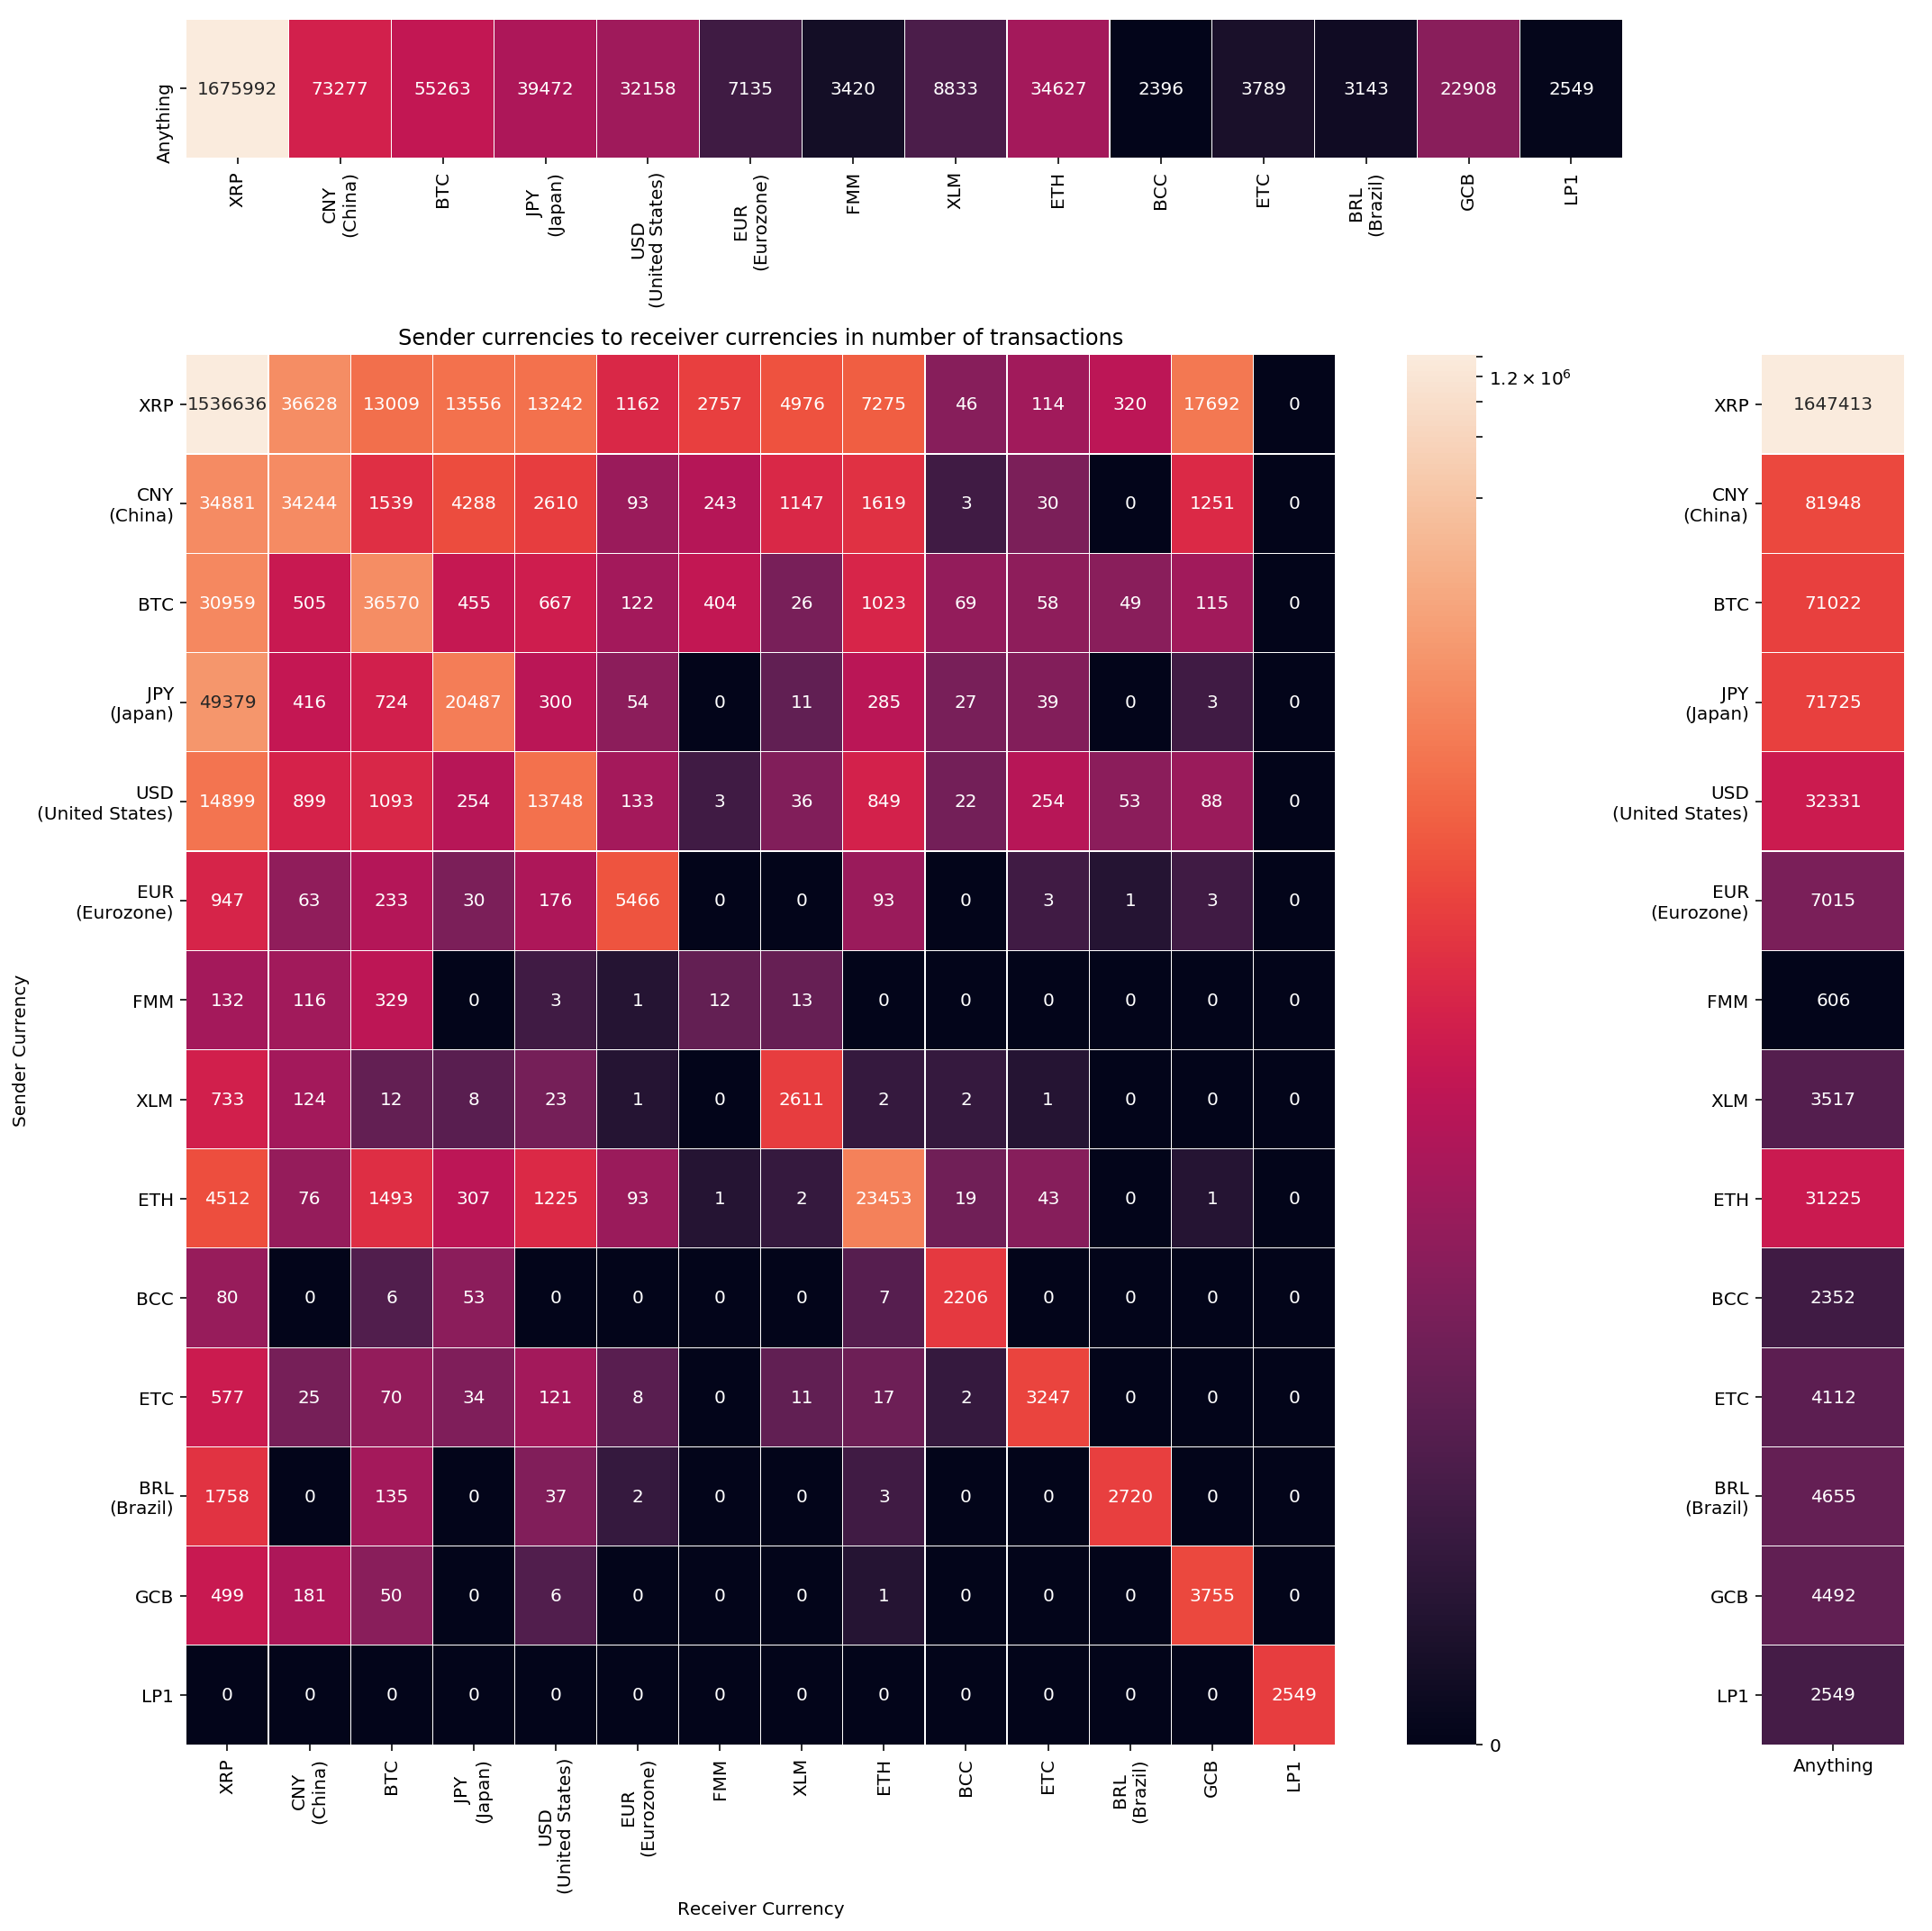

In [19]:
fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [10, 1], 'height_ratios': [1, 10]},figsize=(15,15))
axs[0][1].axis('off')
sns.heatmap(anything_to_currency,annot=True, fmt = "^1.0f", linewidths= 0.1, linecolor = 'white', cbar=False,
                 xticklabels = labels, yticklabels = ['Anything'],
                 norm = SymLogNorm(linthresh=1, linscale=1, vmin=anything_to_currency.min(), vmax=anything_to_currency.max()),ax = axs[0][0])
ax = sns.heatmap(matrix,annot=True, fmt = "^1.0f", linewidths= 0.1, linecolor = 'white',
                 xticklabels = labels, yticklabels = labels, 
                 norm = SymLogNorm(linthresh=1, linscale=1, vmin=matrix.min(), vmax=matrix.max()),ax = axs[1][0])
ax.set_title('Sender currencies to receiver currencies in number of transactions')
ax.set_xlabel('Receiver Currency')
ax.set_ylabel('Sender Currency')
sns.heatmap(currency_to_anything,annot=True, fmt = "^1.0f", linewidths= 0.1, linecolor = 'white', xticklabels = ['Anything'],
                 yticklabels = labels, cbar=False, 
                 norm = SymLogNorm(linthresh=1, linscale=1, vmin=currency_to_anything.min(), vmax=currency_to_anything.max()),ax = axs[1][1])
plt.tight_layout()
plt.savefig('../visualisations/Sender_to_receiver_heatmap.png',dpi = 255)
plt.show()

For top used currencies in senders, what are most popular receiver currencies in terms of volume of XRP

In [30]:
sender_currency_to_receiver_currency_volume = collections.defaultdict(dict) # dict {sender_curr : {receiver_curr: count}}
for txn in tqdm(data):
    if txn['success'] == 'tesSUCCESS':
        sender_curr = txn['senderCurrency']
        receiver_curr = txn['receiverCurrency']
        if sender_curr in currencies.keys() and receiver_curr in currencies.keys():
            sender_currency_to_receiver_currency_volume[sender_curr] = sender_currency_to_receiver_currency_volume.get(sender_curr,{})
            if receiver_curr == 'XRP':
                rate = 1
            else: 
                #try to convert to XRP
                if receiver_curr in currency_to_XRP.keys():
                    rate = currency_to_XRP[receiver_curr]  
                else: 
                    try:
                        rate = c.convert(1, 'USD', receiver_curr) * currency_to_XRP['USD']
                    except ValueError:
                        rate = 0
                
            amount = rate * float(txn['receiverAmount'])
            
            sender_currency_to_receiver_currency_volume[sender_curr][receiver_curr] = sender_currency_to_receiver_currency_volume[sender_curr].get(receiver_curr,0) + amount

We create the matrix for the heat-map

In [31]:
matrix_volume = np.zeros((len(currencies.keys()),len(currencies.keys())))
for sender_currency,repartition in tqdm(sender_currency_to_receiver_currency_volume.items()):
    if sender_currency in list(count_currency.keys())[0:nb_of_top_currencies]:
        for receiver_currency,count in repartition.items():
            if receiver_currency in list(count_currency.keys())[0:nb_of_top_currencies]:
                matrix_volume[currencies[sender_currency],currencies[receiver_currency]] = count

In [32]:
anything_to_currency_volume = matrix_volume.sum(axis = 0,keepdims = True)
currency_to_anything_volume = matrix_volume.sum(axis = 1,keepdims = True)

Plot

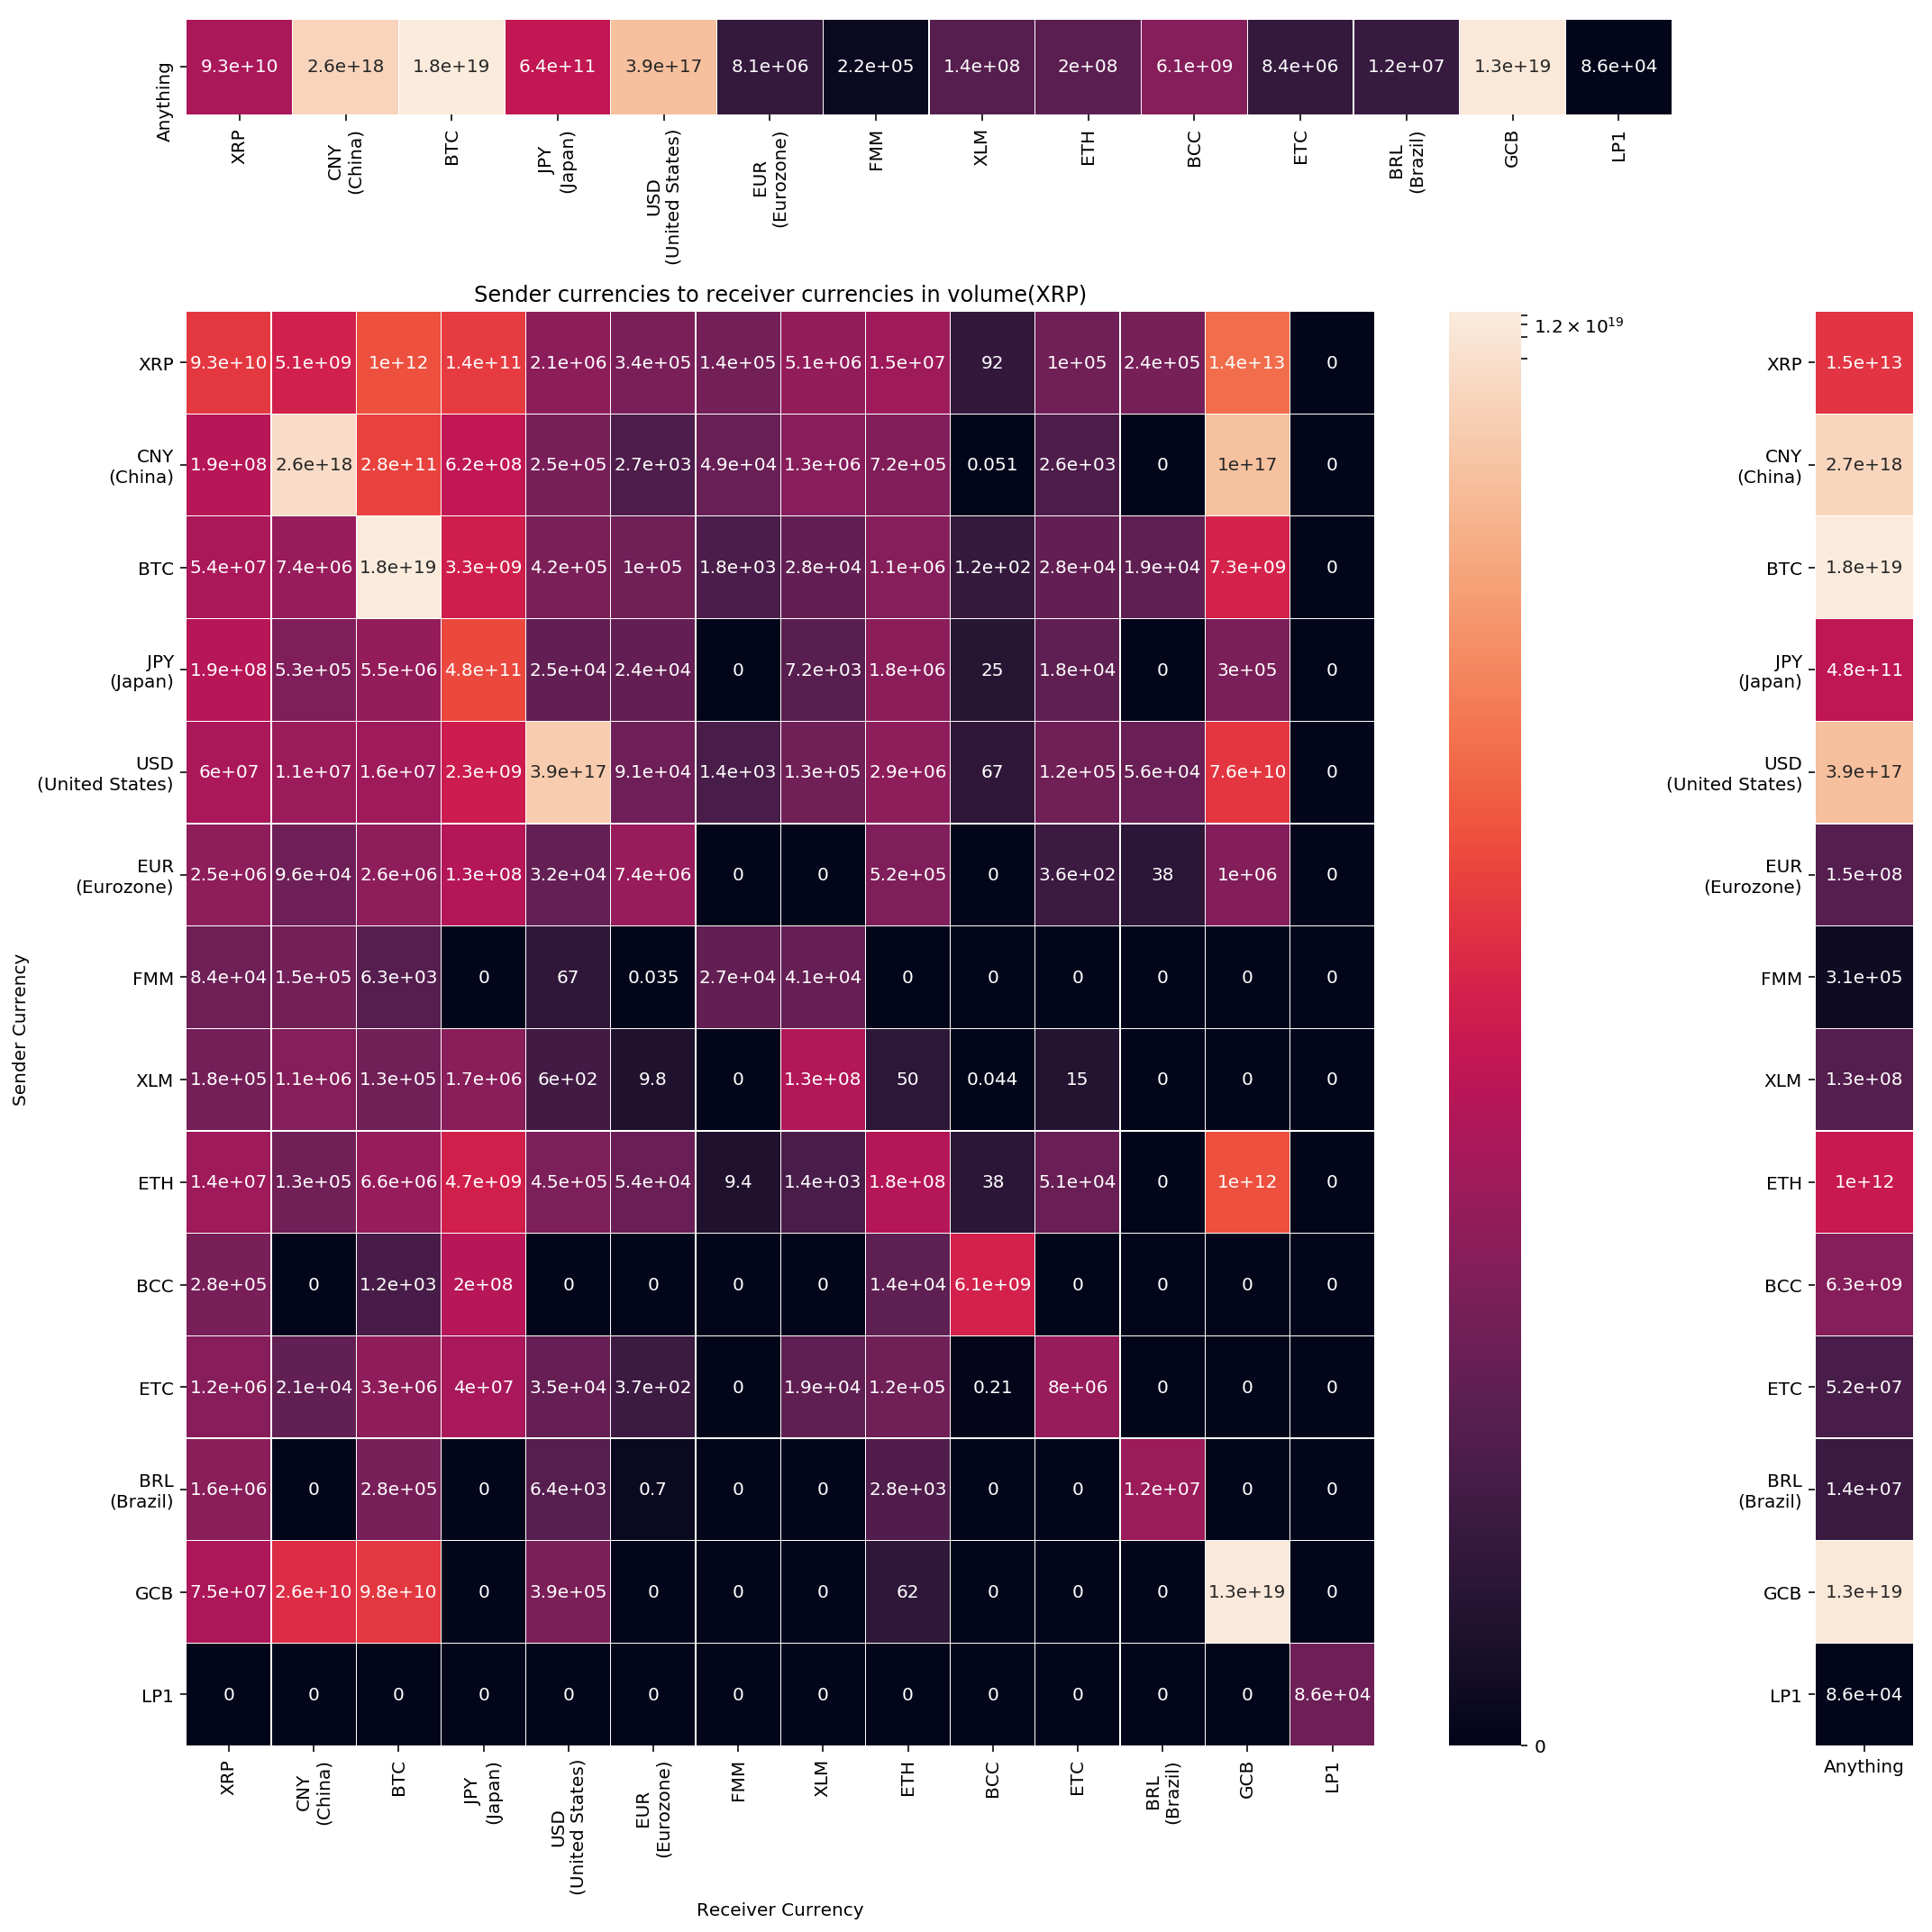

In [35]:
fig, axs = plt.subplots(2, 2, gridspec_kw={'width_ratios': [15, 1], 'height_ratios': [1, 15]},figsize=(15,15))
axs[0][1].axis('off')
sns.heatmap(anything_to_currency_volume,annot=True, linewidths= 0.1, linecolor = 'white', cbar=False,
                 xticklabels = labels, yticklabels = ['Anything'],
                 norm = SymLogNorm(linthresh=1, linscale=1, vmin=anything_to_currency_volume.min(), vmax=anything_to_currency_volume.max()),ax = axs[0][0])
ax = sns.heatmap(matrix_volume, annot=True, linewidths= 0.1, linecolor = 'white',
                 xticklabels = labels, yticklabels = labels, 
                 norm = SymLogNorm(linthresh=1, linscale=1, vmin=matrix_volume.min(), vmax=matrix_volume.max()),ax = axs[1][0])
ax.set_title('Sender currencies to receiver currencies in volume(XRP)')
ax.set_xlabel('Receiver Currency')
ax.set_ylabel('Sender Currency')
sns.heatmap(currency_to_anything_volume,annot=True, linewidths= 0.1, linecolor = 'white', xticklabels = ['Anything'],
                 yticklabels = labels, cbar=False, 
                 norm = SymLogNorm(linthresh=1, linscale=1, vmin=currency_to_anything_volume.min(), vmax=currency_to_anything_volume.max()),ax = axs[1][1])
plt.tight_layout()
plt.savefig('../visualisations/Sender_to_receiver_heatmap_volume.png',dpi = 255)
plt.show()